## Описание обьекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

- Критерии оценки проекта «Промышленность»

    Целевой признак: последняя измеренная температура.

    Метрика: MAE

    Критерии оценки

    - MAE > 8.7 — 0 sp
    - 7.6 < MAE ≤ 8.7 — 4 sp
    - 6.8 < MAE ≤ 7.6 — 4.5 sp
    - 6.3 < MAE ≤ 6.8 — 5 sp
    - 6.0 < MAE ≤ 6.3 — 5.5 sp
    - MAE ≤ 6.0 — 6 sp

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Исследовательский анализ данных

Вам поручили изучить характеристики процесса обработки стали. Для каждого значения столбца key найдите:

- Длительность времени между первым и последним замером температуры.
- Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.
<br>Количество запусков нагрева электродами.
<br>Среднее соотношение потребления активной и реактивной мощности.
<br>По всем полученным столбцам вычислите статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.

In [1]:
!pip install seaborn lightgbm --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)
Requirement already up-to-date: lightgbm in /home/jovyan/.local/lib/python3.7/site-packages (3.2.1)


In [2]:
import pandas as pd
import numpy as np


from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split,cross_val_score
from  sklearn.linear_model import LinearRegression

import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)




#Будем отображать 2 знака после запятой
pd.set_option("precision", 2)

## Подготовка данных

In [3]:
df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Таблица arc 

In [4]:
display(df_arc.tail(7))
df_arc.info()
df_arc.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14869,3240,2019-09-01 03:12:34,2019-09-01 03:17:08,0.98,0.88
14870,3240,2019-09-01 03:31:47,2019-09-01 03:34:08,0.55,0.42
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.53,0.35
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.68,0.52
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.73,0.48
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.22,0.15
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.31,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.00,14876.00,14876.00
mean,1615.22,0.67,0.45
std,934.57,0.41,5.88
min,1.00,0.03,-715.50
25%,806.00,0.40,0.29
50%,1617.00,0.56,0.42
75%,2429.00,0.86,0.64
max,3241.00,3.73,2.68


In [5]:
# провереим верменной ряд на монотонность
print(df_arc['Начало нагрева дугой'].is_monotonic)
df_arc['Конец нагрева дугой'].is_monotonic

False


False

In [6]:
df_arc = df_arc.sort_values(by='Начало нагрева дугой')
print(df_arc['Начало нагрева дугой'].is_monotonic_increasing)
df_arc['Конец нагрева дугой'].is_monotonic_increasing

True


False

После сортировки, данные по концу нагрева не монотонны. Предположим что это  данные с нескольких партий, взятых с разных установок.

In [7]:
df_arc[df_arc['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.5,-715.5


In [8]:
# удалим обнаруженные выбросы
df_arc = df_arc[df_arc['Реактивная мощность'] > 0]

In [9]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14875.00,14875.00,14875.00
mean,1615.19,0.67,0.50
std,934.59,0.41,0.31
min,1.00,0.03,0.02
25%,806.00,0.40,0.29
50%,1617.00,0.56,0.42
75%,2429.00,0.86,0.64
max,3241.00,3.73,2.68


#### Суммарное время нагрева электродами

In [10]:
# приведем тип для работы с датой
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'] )
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'] )

# найдем сколько каждая итерация длилась в секундах
df_arc['Время нагрева'] = df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']
df_arc['Время_нагрева_ceк'] = df_arc['Время нагрева'].apply(lambda x:x.seconds)

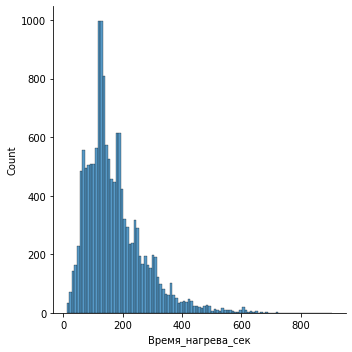

In [11]:
sns.displot(df_arc['Время_нагрева_ceк']);

Видно длинный хвост, будем чистить но нужно спросить у бизнеса.

In [12]:
df_arc.groupby(by='key').count()['Начало нагрева дугой'].describe()

count    3214.00
mean        4.63
std         1.61
min         1.00
25%         4.00
50%         4.00
75%         6.00
max        16.00
Name: Начало нагрева дугой, dtype: float64

In [13]:
df_arc.groupby(by='key').sum()['Время_нагрева_ceк'].describe()

count    3214.00
mean      794.55
std       332.49
min        57.00
25%       571.00
50%       770.00
75%       983.00
max      4189.00
Name: Время_нагрева_ceк, dtype: float64

Посчитаем потребленную мощнгость за каждое время включения печи. 
Возьмем полную мощность как корень из квадратов активной и реактивной и умножим на время работы ковша.

$$ S=\sqrt{P^2+Q^2} $$
 
P — активная ,  Q — реактивная 



In [14]:
df_arc['Потребленная_мощность'] = np.sqrt(df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2)*df_arc['Время_нагрева_ceк']

#### Количество запусков нагрева электродами.

In [15]:
count_electrod = df_arc.groupby(by='key').count().reset_index()[['key','Время_нагрева_ceк']]
count_electrod = count_electrod.rename(columns={"Время_нагрева_ceк":"Количество_запусков_нагрева"})
display(count_electrod)
count_electrod.describe()

,key,Количество_запусков_нагрева
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4
...,...,...
3209,3237,5
3210,3238,3
3211,3239,8
3212,3240,5


,key,Количество_запусков_нагрева
count,3214.00,3214.00
mean,1623.06,4.63
std,934.74,1.61
min,1.00,1.00
25%,817.25,4.00
50%,1623.50,4.00
75%,2431.75,6.00
max,3241.00,16.00


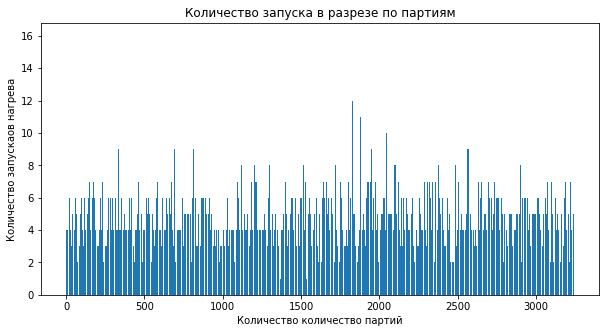

In [16]:
plt.figure(figsize=(10,5))
ax = plt.bar(count_electrod['key'].to_list(),count_electrod['Количество_запусков_нагрева'].to_list());
plt.xlabel('Количество количество партий')
plt.ylabel('Количество запускаов нагрева')
plt.title(f'Количество запуска в разрезе по партиям');

#### Среднее соотношение потребления активной и реактивной мощности.

In [17]:
df_arc['power_diff'] = df_arc['Активная мощность']/df_arc['Реактивная мощность']
df_arc['power_diff'].mean()

1.3606755817252463

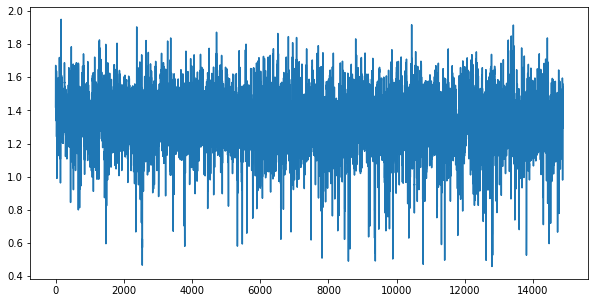

In [18]:
plt.figure(figsize=(10,5))
plt.plot(df_arc['power_diff']);

Как видим активной мощности потребляется больше при технологическом процессе.

In [19]:
df_arc['power_diff'].describe()

count    14875.00
mean         1.36
std          0.17
min          0.46
25%          1.26
50%          1.38
75%          1.48
max          1.95
Name: power_diff, dtype: float64

In [20]:
df_arc_sum = df_arc.groupby(by='key').sum().reset_index().drop(['power_diff'],axis=1)

In [21]:
df_arc_join = count_electrod.merge(df_arc_sum,how='inner', on='key')
df_arc_join

,key,Количество_запусков_нагрева,Активная мощность,Реактивная мощность,Время_нагрева_ceк,Потребленная_мощность
0,1,5,4.88,3.18,1098,1442.38
1,2,4,3.05,2.00,811,881.23
2,3,5,2.53,1.60,655,525.07
3,4,4,3.21,2.06,741,796.91
4,5,4,3.35,2.25,869,1199.14
...,...,...,...,...,...,...
3209,3237,5,3.93,2.83,909,958.34
3210,3238,3,2.11,1.68,546,555.87
3211,3239,8,4.67,3.11,1216,1013.07
3212,3240,5,2.98,2.48,839,729.21


**Вывод:**  По данной таблице были проведены следующие действия:

- Проверен временной ряд на монотонность. Предположительно данные с разных ковшей
- Удалили отридцательные значения по мощности
- Вычислили суммарное время нагрева в каждой партии
- Вычислили количество запусков для каждой партии
- Среднее соотношение потребления активной и реактивной мощности 
- сгруппировали 

### Таблица temperature

In [22]:
df_temp['Температура'].describe()

count    13006.00
mean      1591.84
std         21.38
min       1191.00
25%       1581.00
50%       1591.00
75%       1601.00
max       1705.00
Name: Температура, dtype: float64

In [23]:
df_temp.tail(7)

,key,Время замера,Температура
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


In [24]:
# Первый квартиль (Q1)
Q1 = np.percentile(df_temp['Температура'].dropna(), 25, interpolation = 'midpoint')
# Третий квартиль (Q3)
Q3 = np.percentile(df_temp['Температура'].dropna(), 75, interpolation = 'midpoint')  
# Межквартирный диапазон (IQR)
median =  df_temp['Температура'].median()
IQR = Q3 - Q1
print(IQR, Q1, Q3)
print(Q1 - 3*IQR)
print(Q3 + 3*IQR)

20.0 1581.0 1601.0
1521.0
1661.0


Удалим выбросы, которыхе находятся за 3-х кратным пределом интерквантильного размаха

In [25]:
_index_del_temp = df_temp[(df_temp['Температура']<(Q1 - 3*IQR)) |(df_temp['Температура']>(Q3 + 3*IQR))]['key'].unique()
_index_drop_temp = df_temp.query('key in @_index_del_temp').index
print('Количество удаленных строк',len(_index_drop_temp))
print('Количество удаленных партий',len(_index_del_temp))
df_temperature_join =  df_temp.drop(index=_index_drop_temp)

Количество удаленных строк 241
Количество удаленных партий 42


Мы удалили 241 строку со значениями по температуре по 42 партиям , которые находятся за 3-х кратным пределом интерквантильного размаха

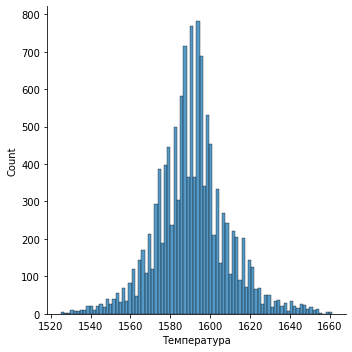

In [26]:
sns.displot(df_temperature_join['Температура'] );

#### Посчитаем количество замеров температуры для каждой партии

In [27]:
df_temp_quant = df_temperature_join.groupby(by='key').count().reset_index()\
.rename(columns={"Время замера":"Количество_замеров температуры"})\
.drop('Температура',axis=1)

In [28]:
_tmp_temperature = df_temperature_join.groupby(by='key').count().reset_index()['Время замера'].value_counts()
#display(_tmp_temperature)
# Посмотрим количество измерений в местах где есть пропуски
_tmp_temperature_na = df_temperature_join[df_temperature_join.isna().any(axis=1)].groupby(by='key').count().reset_index()['Время замера'].value_counts()
#display(_tmp_temperature_na)                    

Построим гистограмм - отношение количества измерений температуры и агрегация этих данных по партиям

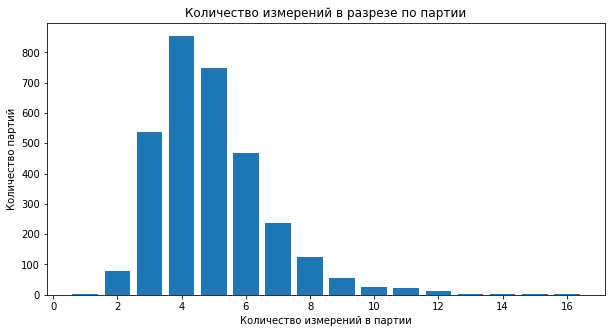

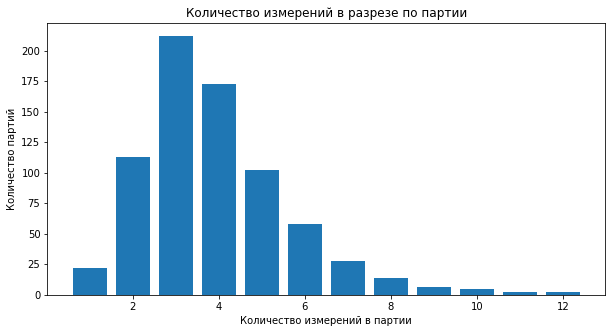

In [29]:
for df in [_tmp_temperature,_tmp_temperature_na]:
    df = df.reset_index().rename(columns={"index":"Temperature_in_key","Время замера":"Quantity_key"})
    plt.figure(figsize=(10,5))
    ax = plt.bar(df['Temperature_in_key'].to_list(),df['Quantity_key'].to_list());
    plt.xlabel('Количество измерений в партии')
    plt.ylabel('Количество партий')
    plt.title(f'Количество измерений в разрезе по партии')

Видим что в рамках одной партии проходит от 1 до 16 измерений температуры, но в основном 3-6 измерений. Так же мы посмотрели измерения для температуры с пропущенными значениями.

In [30]:
df_temperature_join

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [31]:
# Приведем типы данных
df_temperature_join['Время замера'] =df_temperature_join['Время замера'].astype('datetime64[ns]')

#### Длительность времени между первым и последним замером температуры

In [32]:
key_unique = df_temperature_join['key'].unique()
time_measure_temp = []
for key in key_unique:
    _df =df_temperature_join[df_temperature_join['key']==key]
    dfiff_time =_df['Время замера'].max()-_df['Время замера'].min()
    time_measure_temp.append([key,dfiff_time.seconds])
temp_gap = pd.DataFrame(time_measure_temp,columns = ['key','time_gap'])

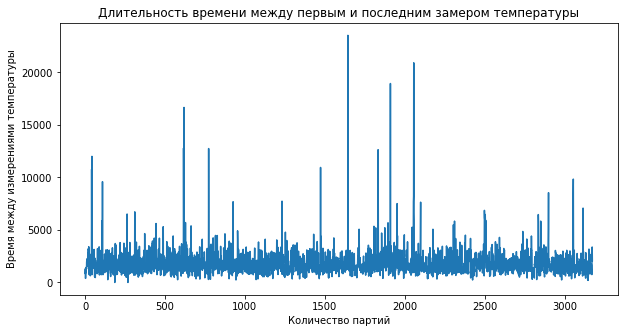

In [33]:
plt.figure(figsize=(10,5))
plt.plot(temp_gap['time_gap']);
plt.title('Длительность времени между первым и последним замером температуры')
plt.xlabel('Количество партий')
plt.ylabel('Время между измерениями температуры');

In [34]:
for key in key_unique:
    df_temperature_join[df_temperature_join['key']==key]    

In [35]:
# приведем тип для работы с датой
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'] )
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'] )

# найдем сколько каждая итерация длилась в секундах
df_arc['Время нагрева'] = df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']
df_arc['Время_нагрева_ceк'] = df_arc['Время нагрева'].apply(lambda x:x.seconds)

Найдем все значения выплавок, где последнее значение температуры было пропущено

In [36]:
key_unique = df_temperature_join['key'].unique()
last_nan_key = []
for key in key_unique:
    len_key_df = df_temperature_join[df_temperature_join['key']==key]['key'].count()
    if pd.isna(df_temperature_join[df_temperature_join['key']==key].iloc[len_key_df-1]['Температура']):  
        last_nan_key.append(key)
df_temperature_join.query('key in @last_nan_key ')

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12271,2501,2019-08-06 03:44:42,1587.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [37]:
df_temperature_join_not_na = df_temperature_join.drop(index=df_temperature_join.query('key in @last_nan_key ').index)
df_temperature_join_not_na.info()
print ('Количество удаленных партий',len(last_nan_key))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12037 entries, 0 to 12266
Data columns (total 3 columns):
key             12037 non-null int64
Время замера    12037 non-null datetime64[ns]
Температура     12037 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 376.2 KB
Количество удаленных партий 737


Как оказалось, если пропущено последнее значение, значит и пропущены все предыдущиие. Теперь в датасэте нет пропусков, мы удалили 737 партий

In [38]:
df_temperature_join_not_na[df_temperature_join_not_na['key']==30]

,key,Время замера,Температура
162,30,2019-05-04 09:35:25,1567.0
163,30,2019-05-04 09:35:57,1567.0
164,30,2019-05-04 09:36:32,1562.0
165,30,2019-05-04 09:46:48,1587.0
166,30,2019-05-04 09:58:56,1605.0
167,30,2019-05-04 10:02:30,1606.0
168,30,2019-05-04 10:09:14,1606.0
169,30,2019-05-04 10:09:50,1598.0


In [39]:
len_key_df = df_temperature_join_not_na[df_temperature_join_not_na['key']==30]['key'].count()
print (len_key_df)
df_temperature_join[df_temperature_join['key']==30]['Температура'].iloc[len_key_df-1]

8


1598.0

Вычислили СКО по температуре по каждой партии(не беря последнее значение), удалили 2 пропуска, т.к. они образовались при делении на 0.

##### Длительность времени между первым и последним замером температуры

In [40]:
key_unique = df_temperature_join['key'].unique()
last_nan_key = []
for key in key_unique:
    len_key_df = df_temperature_join[df_temperature_join['key']==key]['key'].count()
    if pd.isna(df_temperature_join[df_temperature_join['key']==key].iloc[len_key_df-1]['Температура']):  
        last_nan_key.append(key)
df_temperature_join.query('key in @last_nan_key ')

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12271,2501,2019-08-06 03:44:42,1587.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [41]:
key_unique = df_temperature_join['key'].unique()
time_measure_temp = []
for key in key_unique:
    _df =df_temperature_join[df_temperature_join['key']==key]
    dfiff_time =_df['Время замера'].max()-_df['Время замера'].min()
    time_measure_temp.append([key,dfiff_time.seconds])
temp_gap = pd.DataFrame(time_measure_temp,columns = ['key','time_gap'])

In [42]:
temp_gap

,key,time_gap
0,1,861
1,2,1305
2,3,1300
3,4,388
4,5,762
...,...,...
3169,3237,1299
3170,3238,749
3171,3239,3148
3172,3240,3375


Есть идея взять СКО у всех температур кроме последней, в рамках одной партии - **сделаем это!**

In [43]:
key_unique = df_temperature_join_not_na['key'].unique()
std_key = []
for key in key_unique:
    len_key_df = df_temperature_join_not_na[df_temperature_join_not_na['key']==key]['key'].count()
    std = df_temperature_join[df_temperature_join['key']==key]['Температура'][:len_key_df-1].values.std()
    last_temperature = df_temperature_join[df_temperature_join['key']==key]['Температура'].iloc[len_key_df-1]
    first_temperature = df_temperature_join[df_temperature_join['key']==key]['Температура'].iloc[0]
    std_key.append([key,std,last_temperature,first_temperature])     

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
std_key = pd.DataFrame(std_key,columns=['key','std_temp','last_temperature','first_temperature'])
std_key.info()
std_key = std_key.dropna()
std_key.tail(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2437 entries, 0 to 2436
Data columns (total 4 columns):
key                  2437 non-null int64
std_temp             2435 non-null float64
last_temperature     2437 non-null float64
first_temperature    2437 non-null float64
dtypes: float64(3), int64(1)
memory usage: 76.3 KB


,key,std_temp,last_temperature,first_temperature
2430,2493,6.50,1594.0,1599.0
2431,2494,3.50,1591.0,1585.0
2432,2495,10.00,1591.0,1570.0
2433,2496,16.75,1591.0,1554.0
2434,2497,0.00,1589.0,1571.0
2435,2498,9.23,1594.0,1591.0
2436,2499,17.50,1603.0,1569.0


In [45]:
df_temperature_final= temp_gap.merge(std_key,how='inner',on='key')
df_temperature_final=  df_temp_quant.merge(df_temperature_final,how='inner',on='key')
df_temperature_final

,key,Количество_замеров температуры,time_gap,std_temp,last_temperature,first_temperature
0,1,5,861,17.12,1613.0,1571.0
1,2,6,1305,12.29,1602.0,1581.0
2,3,5,1300,1.12,1599.0,1596.0
3,4,3,388,11.00,1625.0,1601.0
4,5,2,762,0.00,1602.0,1576.0
...,...,...,...,...,...,...
2430,2495,3,1137,10.00,1591.0,1570.0
2431,2496,4,1618,16.75,1591.0,1554.0
2432,2497,2,717,0.00,1589.0,1571.0
2433,2498,5,1302,9.23,1594.0,1591.0



**Вывод:**  По данной таблице были проведены следующие действия:

- Удалили выбросы за пределами 3-х интерквантильных размахов
- Удалили партии, где отсутствует последнее значение температуры
- Посчитали количество измерений температур в рамках партии
- Посмотрели распределение по количеству измерений
- Вычислили разницу между первым и последним измерением(секунды)
- Для каждой партии собрали целевой признак ``last_temperature```
- Для каждой партии рассчитали СКО по температурам, не учитывая целевой признак

### Таблица gas

In [46]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


count    3.24e+03
mean     1.10e+01
std      6.22e+00
min      8.40e-03
25%      7.04e+00
50%      9.84e+00
75%      1.38e+01
max      7.80e+01
Name: Газ 1, dtype: float64

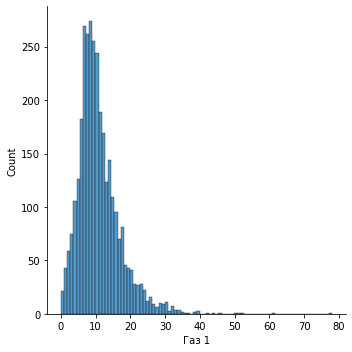

In [47]:
sns.displot(df_gas['Газ 1']);
df_gas['Газ 1'].describe()

In [48]:
df_gas.any()

key      True
Газ 1    True
dtype: bool

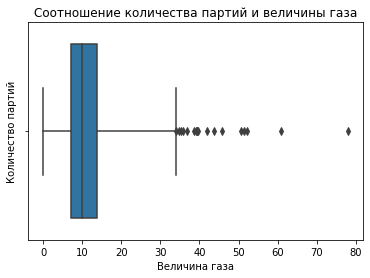

In [49]:
box_plot = sns.boxplot(df_gas['Газ 1'],whis=3)
plt.title('Соотношение количества партий и величины газа')
plt.xlabel('Величина газа')
plt.ylabel('Количество партий');

In [50]:
df_gas = df_gas.rename(columns = {'Газ 1':'gas'})

Удалим явные выбросы по газу

In [51]:
df_gas_join = df_gas[df_gas['gas']<40]
df_gas_join

,key,gas
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41
...,...,...
3234,3237,5.54
3235,3238,6.75
3236,3239,16.02
3237,3240,11.86


**Вывод:** По данной таблице пропусков нет, мы удалили выбросы находящиеся за пределами 3-х кратного интерквантильного размаха. Подготовили данные к обьединению

### Таблица bulk и df_bulk_time

1. Не во всех процессах используются все материалы, для упрощения модели мы предположим что материал есть True или его нет False. Отсутствие материала будем считать пропуском NaN.
<br>  2.Что качсается времени загрузки, eсть идея брать время начала каждого процесса ``"key"`` (из ``data_arc``) потом брать разницу в секундах между началом процесса и загрузкой определенного сыпучего материала ``bulk``.

In [52]:
# визуально взклянем, есть ли различия по пропускам в таблицах
df_bulk.info()
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7 

In [53]:
df_bulk_bool = df_bulk[['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15']].fillna(0)
df_bulk_bool

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
ок, заполяем нулём)

In [54]:
df_bulk_join = pd.merge(df_bulk['key'],df_bulk_bool, right_index = True,
               left_index = True)
df_bulk_join.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0
3128,3241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0


### Таблица bulk и df_bulk_time

Ситуация по таблице схожа с 'bulk', проведем аналогичные операции.

In [55]:
df_wire.info()
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [56]:
df_wire_join = df_wire.fillna(0)

### Обьединение данных

In [57]:
df = (df_wire_join.merge(df_bulk_join, how = 'inner', on = 'key')
                 .merge(df_arc_join, how = 'inner', on = 'key')
                 .merge(df_gas_join, how = 'inner', on = 'key')
                 .merge(df_temperature_final, how = 'inner', on = 'key')
       )
df

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,...,Активная мощность,Реактивная мощность,Время_нагрева_ceк,Потребленная_мощность,gas,Количество_замеров температуры,time_gap,std_temp,last_temperature,first_temperature
0,1,60.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.88,3.18,1098,1442.38,29.75,5,861,17.12,1613.0,1571.0
1,2,96.05,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.05,2.00,811,881.23,12.56,6,1305,12.29,1602.0,1581.0
2,3,91.16,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.53,1.60,655,525.07,28.55,5,1300,1.12,1599.0,1596.0
3,4,89.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.21,2.06,741,796.91,18.84,3,388,11.00,1625.0,1601.0
4,5,89.24,9.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.35,2.25,869,1199.14,5.41,2,762,0.00,1602.0,1576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308,2495,89.15,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.21,2.36,723,778.82,7.13,3,1137,10.00,1591.0,1570.0
2309,2496,114.18,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.20,2.81,940,875.26,9.41,4,1618,16.75,1591.0,1554.0
2310,2497,94.09,9.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.21,1.85,569,556.93,6.27,2,717,0.00,1589.0,1571.0
2311,2498,118.11,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.41,2.36,750,767.82,14.95,5,1302,9.23,1594.0,1591.0


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
ок.

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2313 entries, 0 to 2312
Data columns (total 36 columns):
key                               2313 non-null int64
Wire 1                            2313 non-null float64
Wire 2                            2313 non-null float64
Wire 3                            2313 non-null float64
Wire 4                            2313 non-null float64
Wire 5                            2313 non-null float64
Wire 6                            2313 non-null float64
Wire 7                            2313 non-null float64
Wire 8                            2313 non-null float64
Wire 9                            2313 non-null float64
Bulk 1                            2313 non-null float64
Bulk 2                            2313 non-null float64
Bulk 3                            2313 non-null float64
Bulk 4                            2313 non-null float64
Bulk 5                            2313 non-null float64
Bulk 6                            2313 non-null float64

Проверим данные на мультиколлинеарность

In [59]:
corr_table = df.corr().unstack().sort_values(ascending=False)
corr_table = corr_table.dropna()
display( corr_table[27:57])
#топ 15 по отридцательным корреляциям
display( corr_table[-30:])


Wire 6                       Wire 6                         1.00
Wire 4                       Wire 4                         1.00
Wire 3                       Wire 3                         1.00
Wire 2                       Wire 2                         1.00
Wire 1                       Wire 1                         1.00
std_temp                     std_temp                       1.00
Bulk 9                       Bulk 9                         1.00
key                          key                            1.00
Время_нагрева_ceк            Активная мощность              0.98
Активная мощность            Время_нагрева_ceк              0.98
Bulk 9                       Wire 8                         0.97
Wire 8                       Bulk 9                         0.97
Время_нагрева_ceк            Реактивная мощность            0.96
Реактивная мощность          Время_нагрева_ceк              0.96
                             Активная мощность              0.96
Активная мощность        

last_temperature             Wire 7                        -0.13
Wire 7                       last_temperature              -0.13
Wire 1                       Wire 4                        -0.13
Wire 4                       Wire 1                        -0.13
Bulk 2                       Wire 1                        -0.15
Wire 1                       Bulk 2                        -0.15
Bulk 14                      first_temperature             -0.18
first_temperature            Bulk 14                       -0.18
last_temperature             Bulk 6                        -0.18
Bulk 6                       last_temperature              -0.18
Количество_запусков_нагрева  first_temperature             -0.19
first_temperature            Количество_запусков_нагрева   -0.19
Wire 2                       last_temperature              -0.22
last_temperature             Wire 2                        -0.22
Wire 1                       Bulk 6                        -0.24
Bulk 6                   

Удалим столбцы ``'Bulk 9','Активная мощность','Реактивная мощность','Время_нагрева_ceк'``

In [60]:
df.drop(['Bulk 9','Активная мощность','Реактивная мощность','Время_нагрева_ceк'],axis=1)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,...,Bulk 14,Bulk 15,Количество_запусков_нагрева,Потребленная_мощность,gas,Количество_замеров температуры,time_gap,std_temp,last_temperature,first_temperature
0,1,60.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,150.0,154.0,5,1442.38,29.75,5,861,17.12,1613.0,1571.0
1,2,96.05,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,149.0,154.0,4,881.23,12.56,6,1305,12.29,1602.0,1581.0
2,3,91.16,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,152.0,153.0,5,525.07,28.55,5,1300,1.12,1599.0,1596.0
3,4,89.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,153.0,154.0,4,796.91,18.84,3,388,11.00,1625.0,1601.0
4,5,89.24,9.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,151.0,152.0,4,1199.14,5.41,2,762,0.00,1602.0,1576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308,2495,89.15,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,129.0,223.0,4,778.82,7.13,3,1137,10.00,1591.0,1570.0
2309,2496,114.18,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,129.0,226.0,6,875.26,9.41,4,1618,16.75,1591.0,1554.0
2310,2497,94.09,9.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,124.0,226.0,3,556.93,6.27,2,717,0.00,1589.0,1571.0
2311,2498,118.11,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,129.0,207.0,5,767.82,14.95,5,1302,9.23,1594.0,1591.0


In [61]:
# Проверим, что не осталось сильно коррелирующих признаков

In [62]:
corr_table = df.drop(['Bulk 9','Активная мощность','Реактивная мощность','Время_нагрева_ceк'],axis=1)\
                     .corr().unstack().sort_values(ascending=False).dropna()
display( corr_table[27:57])
#топ 15 по отридцательным корреляциям
display( corr_table[-30:])


Wire 1                          Wire 1                            1.00
std_temp                        std_temp                          1.00
Bulk 7                          Bulk 7                            1.00
key                             key                               1.00
Wire 4                          Bulk 7                            0.71
Bulk 7                          Wire 4                            0.71
                                Bulk 2                            0.70
Bulk 2                          Bulk 7                            0.70
Wire 4                          Bulk 2                            0.70
Bulk 2                          Wire 4                            0.70
Bulk 15                         Bulk 12                           0.64
Bulk 12                         Bulk 15                           0.64
Wire 7                          Wire 4                            0.63
Wire 4                          Wire 7                            0.63
time_g

Bulk 7                       Wire 1                        -0.12
Wire 1                       Bulk 7                        -0.12
Wire 2                       Bulk 12                       -0.12
Bulk 12                      Wire 2                        -0.12
Bulk 2                       Bulk 14                       -0.13
Bulk 14                      Bulk 2                        -0.13
Wire 7                       last_temperature              -0.13
last_temperature             Wire 7                        -0.13
Wire 1                       Wire 4                        -0.13
Wire 4                       Wire 1                        -0.13
Bulk 2                       Wire 1                        -0.15
Wire 1                       Bulk 2                        -0.15
first_temperature            Bulk 14                       -0.18
Bulk 14                      first_temperature             -0.18
Bulk 6                       last_temperature              -0.18
last_temperature         

In [63]:
df = df.drop(['std_temp','key','Bulk 9','Активная мощность','Реактивная мощность','Время_нагрева_ceк'],axis=1)

### Посмотрим выбросы на таргете

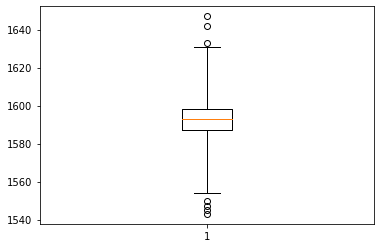

In [64]:
boxplot =   plt.boxplot(df['last_temperature'].values,whis=3);
outliers = boxplot["fliers"][0].get_data()[1]
df_outliers = df[df["last_temperature"].isin(outliers)] 
df_outliers
df = df.drop(index= df_outliers.index)

### Итоговая таблица после обработки

In [65]:
df

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Bulk 1,...,Bulk 13,Bulk 14,Bulk 15,Количество_запусков_нагрева,Потребленная_мощность,gas,Количество_замеров температуры,time_gap,last_temperature,first_temperature
0,60.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,150.0,154.0,5,1442.38,29.75,5,861,1613.0,1571.0
1,96.05,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,149.0,154.0,4,881.23,12.56,6,1305,1602.0,1581.0
2,91.16,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,152.0,153.0,5,525.07,28.55,5,1300,1599.0,1596.0
3,89.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,153.0,154.0,4,796.91,18.84,3,388,1625.0,1601.0
4,89.24,9.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,151.0,152.0,4,1199.14,5.41,2,762,1602.0,1576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308,89.15,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,129.0,223.0,4,778.82,7.13,3,1137,1591.0,1570.0
2309,114.18,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,129.0,226.0,6,875.26,9.41,4,1618,1591.0,1554.0
2310,94.09,9.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,124.0,226.0,3,556.93,6.27,2,717,1589.0,1571.0
2311,118.11,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,129.0,207.0,5,767.82,14.95,5,1302,1594.0,1591.0


План действий :
1. Подготовить все данные к объединению по столбцу ``key``
2. Максимально нагенерить фич в каждой таблице, не забываю про п.1
3. Убрать аномалии в каждой таблице
3. Выделить таргет - в качестве последней температуры. Удалить данные где отсутствует таргет. 
4. Обьединить данные и проверить на мультиколлинеарность
5. Строить модели, смотреть FeatureImportance, побить целевую метрику MAE


### Transform Features


In [66]:
features = df.drop(['last_temperature'],axis=1) 
target = df['last_temperature']
X_train, X_test, y_train, y_test= train_test_split(
features, target, test_size=0.25,shuffle=True, random_state=890)

#### Scaler

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

###  ML models

#### Baseline 

In [68]:
%%time 
dummy_regr = DummyRegressor(strategy="mean")
scores = cross_val_score(dummy_regr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print('MAE:',np.mean(np.abs(scores)))

MAE: 7.883720242589574
CPU times: user 18.9 ms, sys: 54 µs, total: 18.9 ms
Wall time: 16.6 ms


#### LinearRegression

In [69]:
%%time 
model_LR = LinearRegression()
scores = cross_val_score(model_LR, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print('MAE:',np.abs(np.mean(scores)))

MAE: 62627247.3697271
CPU times: user 438 ms, sys: 567 ms, total: 1 s
Wall time: 1.03 s


#### DecisionTreeRegressor

In [70]:
%%time

start_time = time.time()
start = time.time()
model=DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print('MAE:',np.mean(np.abs(scores)))

end = time.time()
#print('The time of execution:',end - start)

MAE: 7.118532371301315
CPU times: user 80.4 ms, sys: 40.2 ms, total: 121 ms
Wall time: 110 ms


In [71]:
%%time 

hyper_param_list = []

def calc_mae(learning_rate):
    
    def mae(y_true, y_pred):
        return mean_absolute_error(y_true,y_pred)
      
    learning_rate = round(learning_rate,2)
    mae = make_scorer(mae, greater_is_better=False)
    sgb = LGBMRegressor(metric='auc',random_state = 890,
                        n_jobs = -1,learning_rate = round(learning_rate,2), silent = True)
    _mae = np.mean(np.abs(cross_val_score(sgb,X_train,y_train,scoring=mae,error_score='raise')))
    return learning_rate,_mae
    #print('The mae is: ',_mae)
    
for learning_rate in np.linspace(0.05, 1.0, num=20):
    learning_rate,_mae = calc_mae(learning_rate)
    hyper_param_list.append([learning_rate,_mae])    
    
hyper_param_list = pd.DataFrame(hyper_param_list,columns=['learning_rate','MAE'])
display(hyper_param_list.sort_values(by='MAE')[:10])

,learning_rate,MAE
0,0.05,5.94
1,0.10,6.06
2,0.15,6.13
3,0.20,6.21
4,0.25,6.37
6,0.35,6.40
5,0.30,6.44
7,0.40,6.59
8,0.45,6.70
9,0.50,6.77


CPU times: user 8min 20s, sys: 3.67 s, total: 8min 24s
Wall time: 8min 27s


### Проверка лучшей модели на тесте

In [72]:
LGBM = LGBMRegressor(metric='auc',random_state = 890,
                        n_jobs = -1,learning_rate = 0.01, silent = True)
model.fit(X_train,y_train)
predict = model.predict(X_test)
print('MAE:',mean_absolute_error(y_test, predict))

MAE: 6.662764915915808


### Feature Importances

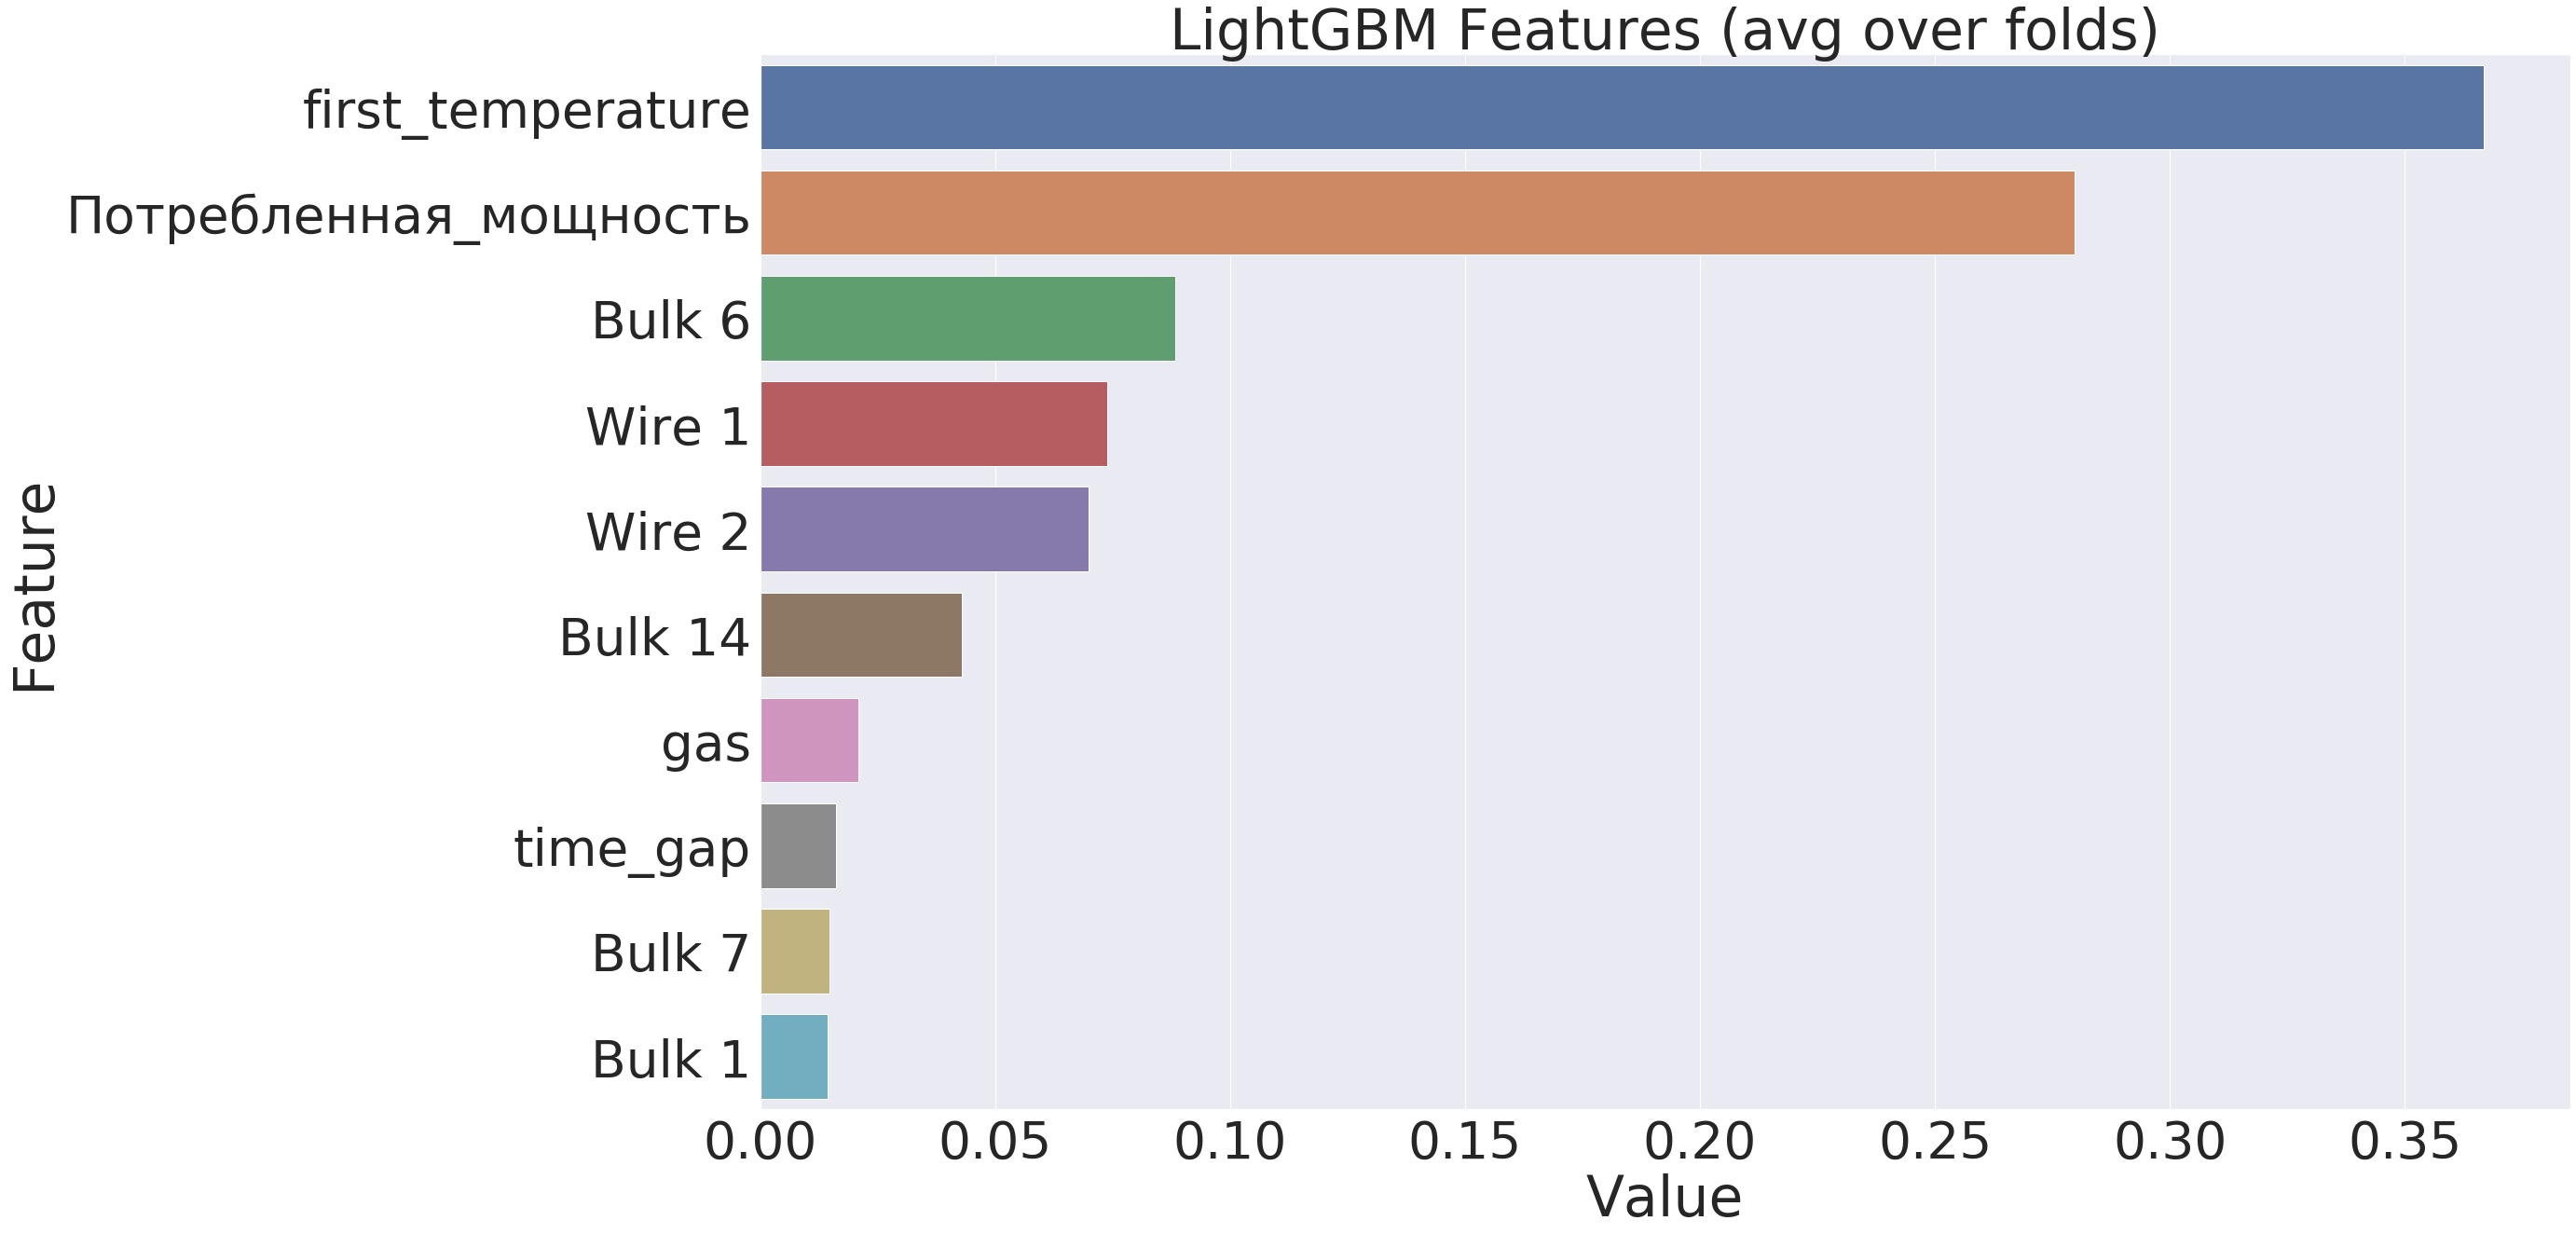

In [73]:
def plotImp(model, X , num = 20, fig_size = (12, 8)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
plotImp(model, pd.DataFrame(X_test), num = 10, fig_size = (40, 20))

**Вывод:**
- Подготовленные фичи разделили на трейнувую и тестувую выборки в соотношении 75-25.
- Провели масштабирование модели. Кодирование не потребовалось, т.к. все фичи были числовые.
- Запустили "Глупую модель", предсказывющую случайным образом. Не ней MAE вышло 8, это был наш бейзлайн.
- Мы попробовали 3 типа моделей : линейные, деревянные и бустинги(анасамбли). Во избежания переобучения моделей, использовали кросс-валидацию.
- Самой лучшей вышла ансамблевая модель градиентного бустинга с метрикой `` 6.48``

### Вывод по работе в целом:

В целях оптимизации расхода энергии заказчику неодимо предсказывать последнюю температуру нагрева тех. процесса плавления. Он будет использовать эти данные и корректировать процесс.

Заказчиком было предложено использовать метрику абсолютных ошибок MAE. Заказчику важно знать, как ошибается модель в абсолютном выражении, чтобы интерпретировать значения для бизнеса.

Были получены данные от заказчика, обьяснен тех процесс работы. Выяснена природа пропуска в данных.

Для повышения последующей точности моделей были удалены нерелевантные данные(выбросы), не соответствующие статистическим критериям или физическим свойствам тех. процесса.

После обработки данных мы протестировали разные типы моделей машинного обучения, по точности оказалось случшая ансамблевая модель градиентного бустинга с метрикой ``MAE:  6.48``, это значит что наша модель ошибкается в предсказаниях всего на 6,5 градусов, что перекрывает его ожидания.`` 6 градусов для него был идеальный результат.``